# Vehicle Detection Project

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from lesson_functions import *
import glob
import time

In [3]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, PredefinedSplit, cross_val_predict, validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [4]:
from scipy.ndimage.measurements import label

In [5]:
# create vehicle img list. We mark whether the data belongs to a certain GTI data directory.

vehicle_GTI_dirs = ['./data/vehicles/GTI_Far/', './data/vehicles/GTI_Left/', './data/vehicles/GTI_MiddleClose/', './data/vehicles/GTI_Right/']
vehicle_img_list = []
GTI_group_ids = []
cgroup_id = 1
for GTI_dir in vehicle_GTI_dirs:
    GTI_current_list = glob.glob(GTI_dir + '*.png')  
    vehicle_img_list = vehicle_img_list + GTI_current_list   
    GTI_group_ids = GTI_group_ids + [np.ones(len(GTI_current_list))*cgroup_id]
    cgroup_id += 1
KTTI_list = glob.glob('./data/vehicles/KITTI_extracted/*.png')
vehicle_img_list = vehicle_img_list+ KTTI_list
vehicle_group_id = np.concatenate(GTI_group_ids + [np.zeros(len(KTTI_list))])

# create non vehicle img list and group ids for non-vehicle data
non_vehicle_img_list = glob.glob('./data/non-vehicles/GTI/*.png') + glob.glob('./data/non-vehicles/Extras/*.png')
non_vehicle_group_id = np.zeros(len(non_vehicle_img_list))

# load all images
vehicle_images =  [cv2_readRGB(w) for w in vehicle_img_list]
non_vehicle_images =  [cv2_readRGB(w) for w in non_vehicle_img_list]
group_id = np.concatenate([vehicle_group_id, non_vehicle_group_id]).astype(int)

In [6]:
from sklearn.utils import shuffle
def obtain_fold_group(group_id,K):
    # divide data into K folds and return the fold index each sample belongs to
    test_fold_index = np.zeros_like(group_id)
    for c_id in np.unique(group_id):
        n_sample_in_group = np.sum(group_id == c_id)
        if c_id ==0:
            test_fold_index[group_id == c_id] = shuffle(np.floor_divide(np.arange(0, n_sample_in_group), np.ceil(n_sample_in_group/K)),random_state=0) 
        else:
            test_fold_index[group_id == c_id] = np.floor_divide(np.arange(0, n_sample_in_group), np.ceil(n_sample_in_group/K))
    return test_fold_index.astype(int)            

In [7]:
fold_indices = obtain_fold_group(group_id, 5)

In [8]:
orient = 9  # HOG orientations
color_space = 'LUV' 
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = [0,1] # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [9]:
car_features = extract_features(vehicle_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_vehicle_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [10]:
X_test = scaled_X[fold_indices==0,:]
y_test = y[fold_indices==0]
X_train_validate = scaled_X[fold_indices!=0,:]
y_train_validate = y[fold_indices!=0]
fold_train_validate = fold_indices[fold_indices!=0]

## Search for Best SVM parameter

In [11]:
X.shape

(17760, 4344)

In [12]:
# test errors
clf = LinearSVC(C=1)
t=time.time()
clf.fit(X_train_validate, y_train_validate)
t2 = time.time()
print('Test Accuracy of Classifier = ', round(clf.score(X_test, y_test), 4))

Test Accuracy of Classifier =  0.993


## Set windows

In [14]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def search_cars(img, x_start_stop, y_start_stop, xy_window, xy_overlap,              
                clf, X_scaler, color_space, hog_channel, orient, pix_per_cell, cell_per_block, spatial_size,
                hist_bins, spatial_feat=spatial_feat, 
                hist_feat=hist_feat, hog_feat=hog_feat): 
    """apply the vehicle/non-vehicle classifier to a set of windows defined by x_start_stop, y_start_stop, xy_window, xy_overlap
    
    This function precompute the Hog feature cross the entire applicable region
    """
    window_size = 64
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_steps = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_steps = np.int((yspan-ny_buffer)/ny_pix_per_step) 


    # remove extra region that are not covered by window in xspan, yspan definition
    xspan = nx_pix_per_step*nx_steps+nx_buffer
    yspan = nx_pix_per_step*ny_steps+nx_buffer

    nblocks_per_window = (window_size // pix_per_cell) - cell_per_block + 1
    nx_cell_per_step = np.int(window_size//pix_per_cell*(1 - xy_overlap[0])) 
    ny_cell_per_step = np.int(window_size//pix_per_cell*(1 - xy_overlap[1]))

    # convert the window and step size setting to the resized image


    img_region_for_search = img[y_start_stop[0]:(y_start_stop[0]+yspan),x_start_stop[0]:(x_start_stop[0]+xspan)]
    xyspan_resized =(pix_per_cell* nx_cell_per_step * (nx_steps-1) + window_size,
                     pix_per_cell* ny_cell_per_step * (ny_steps-1) + window_size)
    x_scale = np.float32(xyspan_resized[0]) / xspan
    y_scale = np.float32(xyspan_resized[1]) / yspan
    img_region_resized = cv2.resize(img_region_for_search, xyspan_resized)


    # Initialize a list to append window positions to                            
    color_space_image = convert_RGB_to_color_space(img_region_resized, color_space)
    hog_featgures_whole_image = [get_hog_features(color_space_image[:,:,w],
                                                  orient, pix_per_cell, cell_per_block, feature_vec=False)
                                 for w in hog_channel]
        
    on_windows = []
    for xb in range(nx_steps):
        for yb in range(ny_steps):
            ypos = yb*nx_cell_per_step
            xpos = xb*ny_cell_per_step
            # Extract HOG for this patch
            hog_features = np.ravel([w[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() for w in hog_featgures_whole_image])

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = color_space_image[ytop:ytop+window_size, xleft:xleft+window_size]#, (64,64)

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)

            if test_prediction == 1:
                x_window_start = x_start_stop[0]+np.int(xleft*x_scale)
                y_window_start = y_start_stop[0]+np.int(ytop*y_scale)
                on_windows.append(((x_window_start, y_window_start),
                                   (x_window_start+xy_window[0], y_window_start+xy_window[1])))
    return on_windows, xyspan_resized                               

In [15]:
test_image_files = glob.glob('./test_images/*.jpg')
test_images = [cv2_readRGB(w) for w in test_image_files]

In [16]:
slide_windows = [{'x_start_stop':[None, None], 'y_start_stop':[380, 550], 'xy_window':(64, 64), 'xy_overlap':(0.75, 0.75)},
                 {'x_start_stop':[None, None], 'y_start_stop':[380, 600], 'xy_window':(96, 96), 'xy_overlap':(0.875, 0.875)},
                 {'x_start_stop':[None, None], 'y_start_stop':[380, 700], 'xy_window':(128, 128), 'xy_overlap':(0.875, 0.875)},
                 {'x_start_stop':[None, None], 'y_start_stop':[380, 700], 'xy_window':(160, 160), 'xy_overlap':(0.875, 0.875)}
                ]                

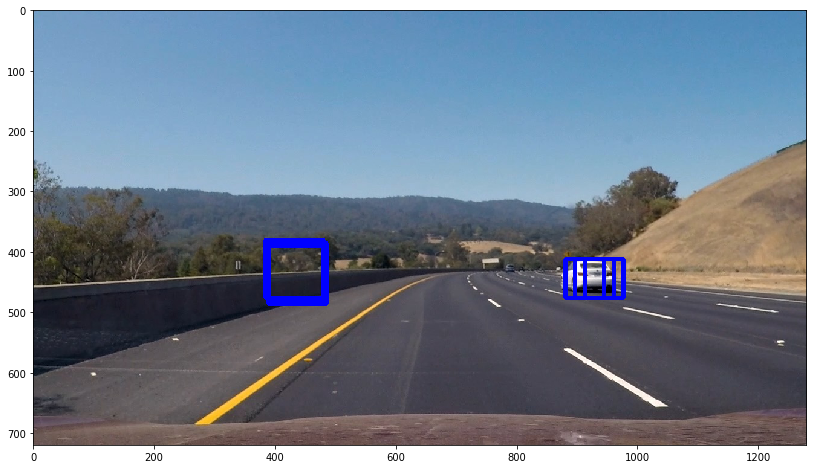

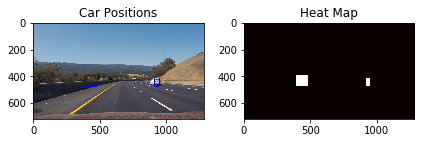

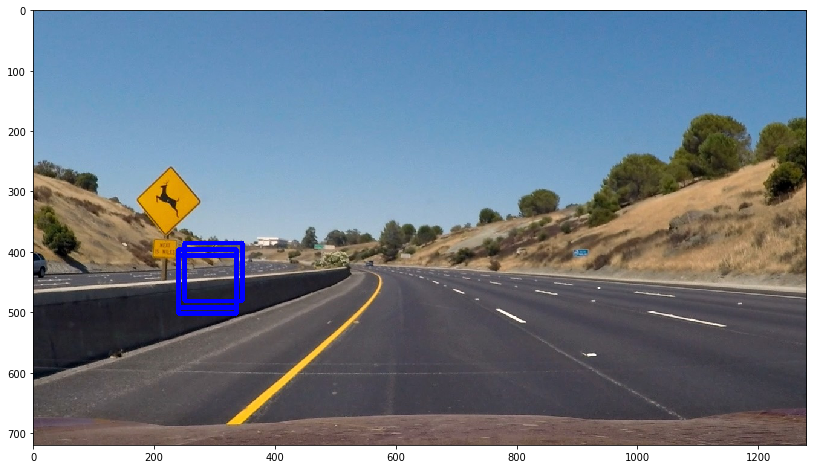

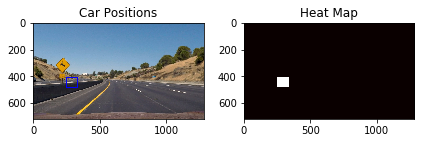

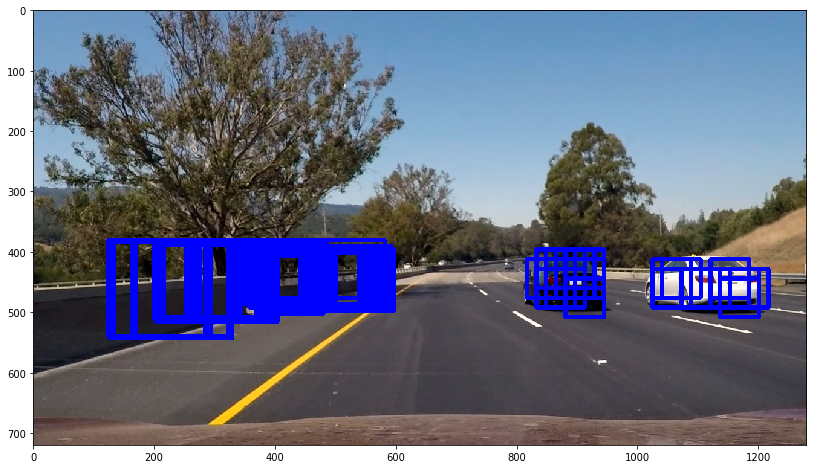

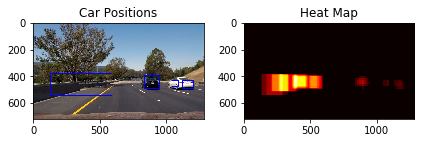

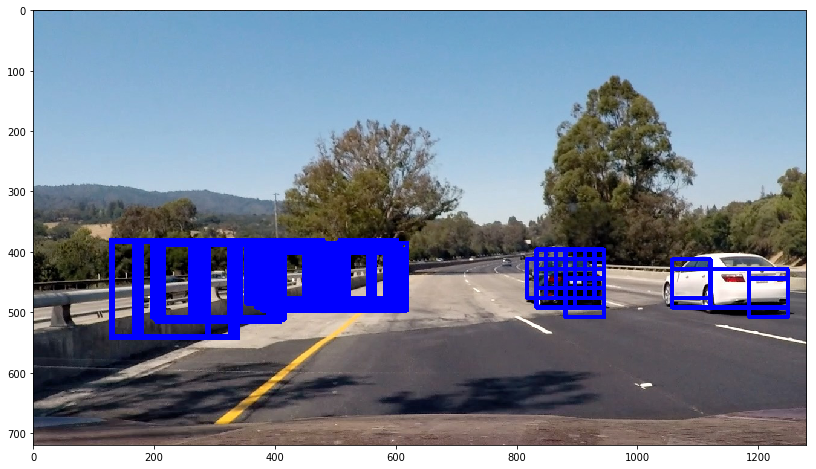

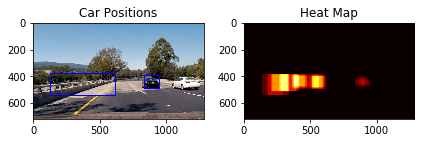

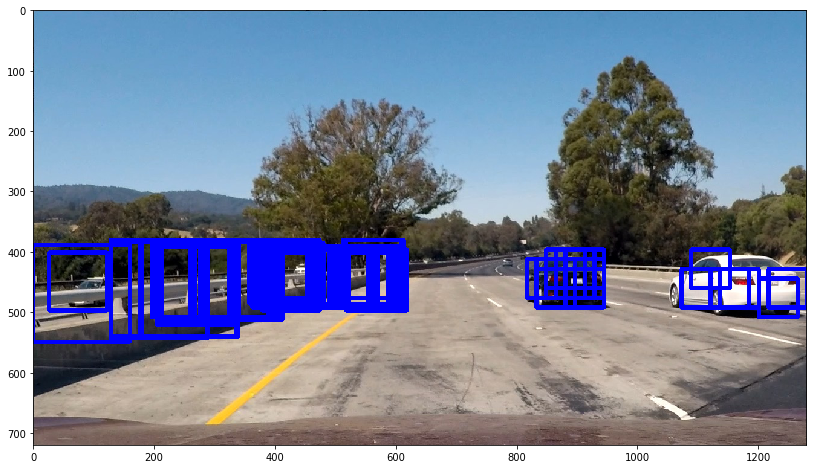

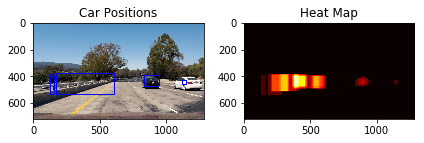

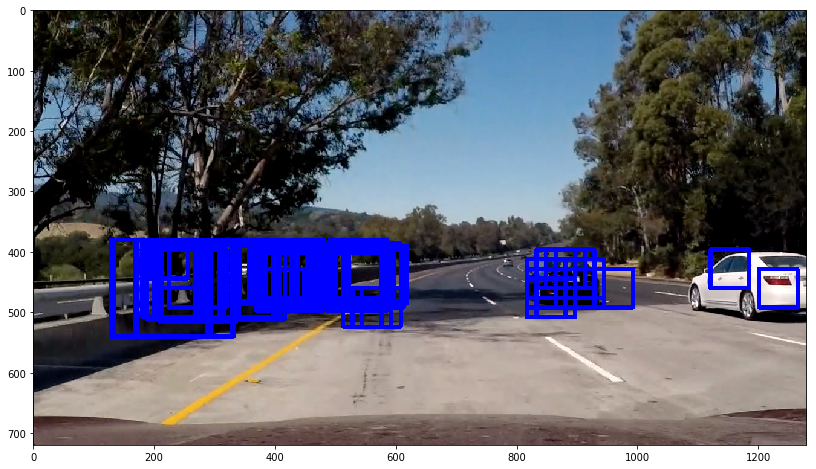

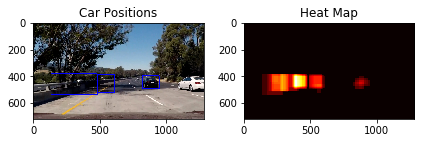

In [18]:
for test_image in test_images:

    hot_windows = []
    for window_group in slide_windows:
        hot_windows_current_group, xyspan_resized = search_cars(test_image,
                                                                x_start_stop=window_group['x_start_stop'],
                                                                y_start_stop=window_group['y_start_stop'],
                                                                xy_window=window_group['xy_window'],
                                                                xy_overlap=window_group['xy_overlap'],
                                                                clf=clf, X_scaler=X_scaler,
                                                                color_space=color_space, 
                                                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                                                orient=orient, pix_per_cell=pix_per_cell, 
                                                                cell_per_block=cell_per_block, 
                                                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                                                hist_feat=hist_feat, hog_feat=hog_feat)                       
        hot_windows = hot_windows + hot_windows_current_group
    draw_image = np.copy(test_image)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    plt.figure(figsize=(20,8))
    plt.imshow(window_img)
    heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat,2)
    

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(test_image), labels)
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

In [ ]:
class Car():
    def __init__(self, initial_p=0.5, centroid=None, bbox=None):        
        self.p = initial_p
        # x values of the last n fits of the line
        self.centroid = centroid # center of the box parameter  (x,y)  
        self.bbox = bbox
        #self.shape = None # box parameter of the car   

In [ ]:
car_collection = []

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

In [ ]:
clip = VideoFileClip("test_video.mp4")

In [ ]:
np.arange(0,1, 1.0/25)

In [ ]:
test_images = [clip.get_frame(t) for t in np.arange(0,1, 1.0/25)]

In [ ]:
for test_image in test_images:
    plt.figure()
    plt.imshow(test_image)

In [ ]:
def get_labeled_bboxes(labels):
    if labels[1]>=1:
        bbox = np.zeros((labels[1], 4))
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox[car_number-1,:] = np.array([np.min(nonzerox), np.min(nonzeroy), np.max(nonzerox), np.max(nonzeroy)])        
    else:
        bbox = None
    return bbox


In [ ]:

dist_thres = 100
alpha=0.7

In [ ]:
car_collection = []
for test_image in test_images:

    hot_windows = []
    for window_group in slide_windows:
        hot_windows_current_group, xyspan_resized = search_cars(test_image,
                                                                x_start_stop=window_group['x_start_stop'],
                                                                y_start_stop=window_group['y_start_stop'],
                                                                xy_window=window_group['xy_window'],
                                                                xy_overlap=window_group['xy_overlap'],
                                                                clf=clf, X_scaler=X_scaler,
                                                                color_space=color_space, 
                                                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                                                orient=orient, pix_per_cell=pix_per_cell, 
                                                                cell_per_block=cell_per_block, 
                                                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                                                hist_feat=hist_feat, hog_feat=hog_feat)                       
        hot_windows = hot_windows + hot_windows_current_group
    draw_image = np.copy(test_image)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    plt.figure(figsize=(20,8))
    plt.imshow(window_img)
    heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat,2)
    

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    bbox = get_labeled_bboxes(labels)    
    if bbox is not None:
        bbox_centers = np.stack([(bbox[:,0]+bbox[:,2])/2, (bbox[:,1]+bbox[:,3])/2], axis=1)
        flag = np.zeros(bbox.shape[0])
    for car in car_collection:
        if bbox is not None:
            distances = np.sqrt(np.sum((bbox_centers - car.centroid)**2,axis=1))
            min_index = np.argmin(distances)
            if distances[min_index] > dist_thres:
                min_index = None
        else:
            min_index = None
        if min_index:
            car.p = car.p * alpha + (1-alpha)
            car.centroid = car.centroid * alpha + bbox_centers[min_index,:] * (1-alpha)
            car.bbox = car.bbox * alpha + bbox[min_index, :] * (1-alpha)
            flag[min_index]=1
        else:
            car.p = car.p * alpha        
            
    if bbox is not None:
        new_detected = bbox[flag==0,:]
        for new_box in new_detected:
            car_collection.append(Car(initial_p=0.5,
                                      centroid=np.array([(new_box[0]+new_box[2])/2, (new_box[1]+new_box[3])/2]),
                                      bbox = new_box))
                
    # remove object with low probability        
    car_collection = [w for w in car_collection if w.p>=0.2]
    #x_centroid = np.median(nonzero[1])
    #y_centroid = np.median(nonzero[0])
    draw_img = draw_labeled_bboxes(np.copy(test_image), labels)
    fig = plt.figure(figsize=(20,4))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    
    draw_img = np.copy(test_image)
    for car in car_collection:   
        # Draw the box on the image
        if car.p>=0.6:
            cbbox = car.bbox.astype(int)
            cv2.rectangle(draw_img, (cbbox[0],cbbox[1]), (cbbox[2],cbbox[3]), (0,255,0), 6)
    fig = plt.figure(figsize=(20,8))
    plt.imshow(draw_img)
    plt.title('Car Positions')

In [ ]:
[w.p for w in car_collection]

In [ ]:
s=car_collection[0]

In [ ]:
s.detected